In [2]:
import os, time, re
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nabstab.utils import load_model, test_model
from nabstab.constants import AA2INDEX, IDX2AA
from nabstab.datasets.classifier_dataset import pad_cdr2, NbStabilityDataset

In [3]:
## Get the paths setup
if '__file__' in globals():
    current_dir = Path(__file__).resolve().parent
else:
    current_dir = Path.cwd()

data_dir = current_dir.parent / 'data'
checkpoints_dir = current_dir.parent / 'model_checkpoints'

In [5]:
test_set = data_dir / 'model_training_data/ENN_test.csv'
test_df = pd.read_csv(test_set)
test_df_equal = pd.concat([test_df[test_df.stability == 'high'].sample(50000), test_df[test_df.stability == 'low'].sample(50000)])

In [19]:
lr_checkpoint = checkpoints_dir / 'LR/20231223_LR.pt'
lr_cdr12_checkpoint = checkpoints_dir / 'LR/cdr12.pt'
cnn_checkpoint = checkpoints_dir / 'CNN/cnn_24_fc_8.pt'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#load models
lrmodel = load_model(
    checkpoint_path=lr_checkpoint,
    model_type='lr',
    device=device
)

lrmodel_cdr12 = load_model(
    checkpoint_path=lr_cdr12_checkpoint,
    model_type='lr',
    sequence_length = 20,
    device=device
)

cnnmodel = load_model(
    checkpoint_path=cnn_checkpoint,
    model_type='cnn',
    device=device
)


In [7]:
roc_auc_lr, fpr_lr, tpr_lr = test_model(lrmodel, test_df_equal, device)
roc_auc_cnn, fpr_cnn, tpr_cnn = test_model(cnnmodel, test_df_equal, device)

In [8]:
#check the performance of the cdr1 and 2 model:
test_df['cdr2_padded'] = test_df['CDR2'].apply(pad_cdr2)
test_df['padded_sequence'] = test_df['CDR1'] + test_df['cdr2_padded']
sequences = list(test_df['padded_sequence'].values)
numseqs = torch.vstack([torch.tensor([AA2INDEX[aa] for aa in seq], dtype=torch.long) for seq in sequences])
preds = []
lrmodel_cdr12.eval()

batch_size = 256
for i in range(0, numseqs.shape[0], batch_size):
    batch = numseqs[i:i+batch_size].to(device)
    with torch.no_grad():
        preds.append(lrmodel_cdr12.predict(batch, return_logits=True))
all_preds = np.vstack(preds)

In [9]:
labels = np.array(test_df['stability'] == 'high', dtype=int)
roc_auc_lr_cdr12 = roc_auc_score(labels, all_preds)
fpr_lr_cdr12, tpr_lr_cdr12, _ = roc_curve(labels, all_preds)

We also evaluated TANGO on this dataset. [TANGO](https://www.nature.com/articles/nbt1012), which predicts the aggregation propensity of sequence segments.

This can by done by using the following command:
```bash
python scripts/run_tango.py --input_file path/to/file --output_dir /path/to/output_dir 
```

To run as-is, one must provide a dataframe with the following columns:
- `CDR1`
- `CDR2`
- `CDR3`

In [10]:
tango_df_file = data_dir / 'tango_output' / 'tango_results.csv'
tango_df = pd.read_csv(tango_df_file)

In [11]:
#total_agg_score is the best score. It's inversely correlated (high score here is more prone to aggregation)

labels_tango = np.array(tango_df['stability'] == 'high', dtype=int)
roc_auc_tango = roc_auc_score(labels_tango, -tango_df['total_agg_score'])
fpr_tango, tpr_tango, _ = roc_curve(labels_tango, -tango_df['total_agg_score'])

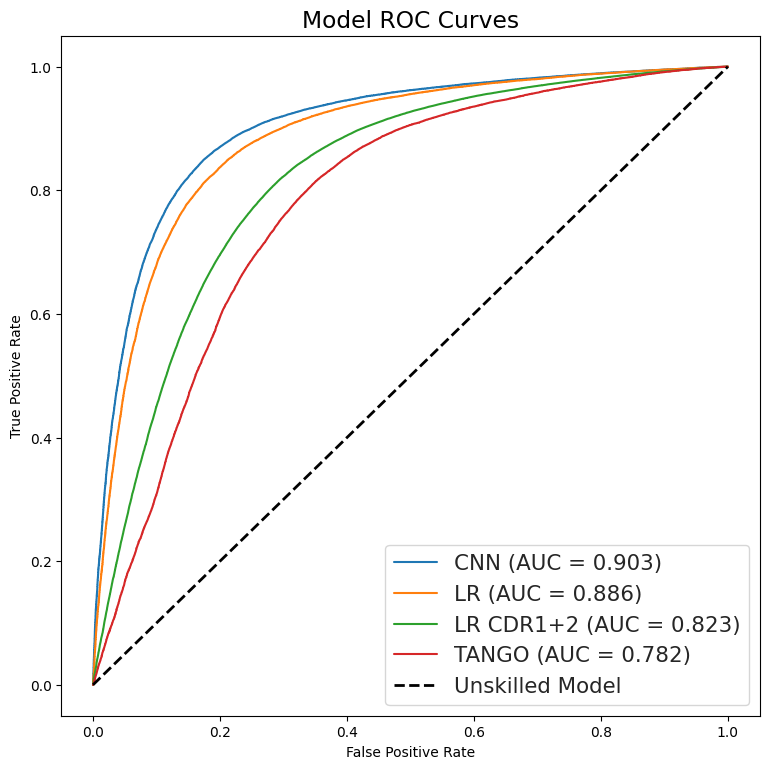

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

sns.set_theme(style='white', palette='colorblind', font_scale=1.4)
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.minor.left'] = True

axs.plot(fpr_cnn, tpr_cnn, label=f'CNN (AUC = {roc_auc_cnn:.3f})')
axs.plot(fpr_lr, tpr_lr, label=f'LR (AUC = {roc_auc_lr:.3f})')
axs.plot(fpr_lr_cdr12, tpr_lr_cdr12, label=f'LR CDR1+2 (AUC = {roc_auc_lr_cdr12:.3f})')
axs.plot(fpr_tango, tpr_tango, label=f'TANGO (AUC = {roc_auc_tango:.3f})')

axs.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Unskilled Model')
axs.set_xlabel('False Positive Rate')
axs.set_ylabel('True Positive Rate')
axs.set_title('Model ROC Curves')
axs.legend()

axs.spines['left'].set_visible(True)
axs.spines['bottom'].set_visible(True)

plt.tight_layout()
plt.savefig(current_dir/ 'figure_3_outputs'/ 'roc_curve.pdf')

In [13]:
#save the curves as a csv, every 20th point
for condition in ['cnn', 'lr', 'lr_cdr12', 'tango']:
    fpr = eval(f'fpr_{condition}')
    tpr = eval(f'tpr_{condition}')
    with open(current_dir / 'figure_3_outputs' / f'{condition}_roc_curve.csv', 'w') as f:
        f.write('fpr,tpr\n')
        for i in range(0, len(fpr), 40):
            f.write(f'{fpr[i]},{tpr[i]}\n')


General statistics of the models - how well do they separate the two classes?

In [14]:
test_numseqs = torch.vstack([torch.tensor([AA2INDEX.get(aa, 20) for aa in seq], dtype=torch.long) for seq in test_df_equal.seq.values])
test_preds_lr = []
test_preds_cnn = []
for i in np.arange(0, test_numseqs.shape[0], 1024):
    batch = test_numseqs[i:i+1024].to(device)
    with torch.no_grad():
        test_preds_lr.append(lrmodel.predict(batch, return_logits=True))
        test_preds_cnn.append(cnnmodel.predict(batch, return_logits=True))

test_preds_lr = np.vstack(test_preds_lr)
test_preds_cnn = np.vstack(test_preds_cnn)

test_df_equal['lr_pred'] = test_preds_lr
test_df_equal['cnn_pred'] = test_preds_cnn


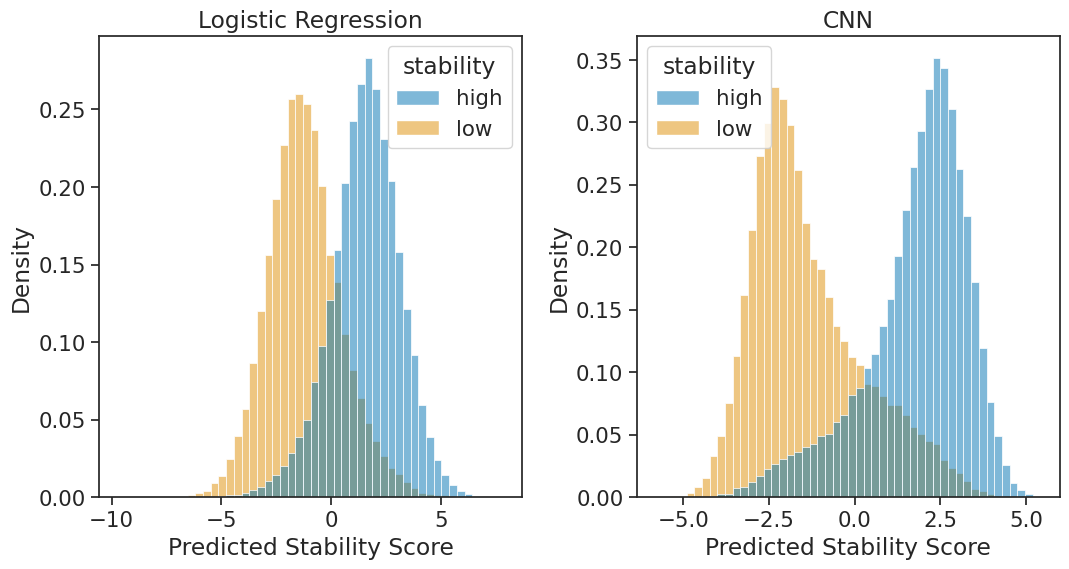

In [15]:
fig, ax = plt.subplots(1,2, figsize=(11,6))

g = sns.histplot(data=test_df_equal, x='lr_pred', hue='stability', ax=ax[0], bins=50, stat='density', common_norm=False, alpha=0.5)
ax[0].set_xlabel('Predicted Stability Score')
ax[0].set_ylabel('Density')
ax[0].set_title('Logistic Regression')


g2 = sns.histplot(data=test_df_equal, x='cnn_pred', hue='stability', ax=ax[1], bins=50, stat='density', common_norm=False, alpha=0.5)
ax[1].set_xlabel('Predicted Stability Score')
ax[1].set_ylabel('Density')
ax[1].set_title('CNN')

fig.tight_layout()
save_path = current_dir / 'figure_3_outputs' / 'predicted_stability_scores.pdf'
plt.savefig(save_path)

#also save the histograms as csv files
for model in ['lr', 'cnn']:
    #split by stability
    data = []
    #get the bin edges already sorted
    _, bin_edges = np.histogram(test_df_equal[f'{model}_pred'], bins=50, density=True)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    for stability in ['high', 'low']:
        hist, _ = np.histogram(test_df_equal[test_df_equal.stability == stability][f'{model}_pred'], bins=bin_edges, density=True)
        for center, density in zip(bin_centers, hist):
            data.append([stability, center, density])
    hist_df = pd.DataFrame(data=data, columns=['stability', 'bin_center', 'density'])
    hist_df.to_csv(current_dir / 'figure_3_outputs' / f'{model}_predicted_stability_scores_histogram.csv', index=False)

## Other EDA

Let's also look at some biophysical and sequence properties that may explain some of this data

In [1]:
from scipy import stats

In [4]:
train_set = data_dir / 'model_training_data/ENN_train.csv'
train_df = pd.read_csv(train_set).groupby('stability').apply(lambda x: x.sample(100000, random_state=42)).reset_index(drop=True)

In [5]:
AROMATIC_RE = re.compile('[FYWH]')
HYDROPHOBIC_RE = re.compile('[AVMLIFCW]')
LARGE_RE = re.compile('[FYHMLWQEIRK]')
POSITIVE_RE = re.compile('[RKH]')
NEGATIVE_RE = re.compile('[DE]')

In [6]:
def analyze_cdr_patterns(df):
    # Define regex patterns
    patterns = {
        'aromatic': r'[FYWH]',
        'hydrophobic': r'[AVMLIFCW]',
        'large': r'[FYHMLWQEIRK]',
        'positive': r'[RKH]',
        'negative': r'[DE]'
    }
    
    # Function to calculate fraction of matches for a pattern
    def get_pattern_fraction(sequence, pattern):
        matches = len(re.findall(pattern, sequence))
        return matches / len(sequence)

    # Analyze CDR1 and CDR2 combined
    results_12 = []
    for _, row in df.iterrows():
        combined_seq = row['CDR1'] + row['CDR2']
        fractions = {
            'Fitness': row['stability'],
            'sequence_length': len(combined_seq)
        }
        for name, pattern in patterns.items():
            fractions[f'frac_{name}'] = get_pattern_fraction(combined_seq, pattern)
        results_12.append(fractions)
    
    # Analyze CDR3 separately
    results_3 = []
    for _, row in df.iterrows():
        fractions = {
            'Fitness': row['stability'],
            'sequence_length': len(row['CDR3'])
        }
        for name, pattern in patterns.items():
            fractions[f'frac_{name}'] = get_pattern_fraction(row['CDR3'], pattern)
        results_3.append(fractions)
    
    return pd.DataFrame(results_12), pd.DataFrame(results_3)

def perform_statistical_tests(df_12, df_3):
    feature_cols = [col for col in df_12.columns if col.startswith('frac_')]
    
    stats_results = {
        'CDR1_2': {},
        'CDR3': {}
    }
    
    # Perform t-tests for CDR1_2
    for feature in feature_cols:
        high = df_12[df_12['stability'] == 'high'][feature]
        low = df_12[df_12['stability'] == 'low'][feature]
        t_stat, p_val = stats.mannwhitneyu(high, low)
        stats_results['CDR1_2'][feature] = {
            't_statistic': t_stat,
            'p_value': p_val,
            'mean_high': high.mean(),
            'mean_low': low.mean()
        }
    
    # Perform t-tests for CDR3
    for feature in feature_cols:
        high = df_3[df_3['stability'] == 'high'][feature]
        low = df_3[df_3['stability'] == 'low'][feature]
        t_stat, p_val = stats.mannwhitneyu(high, low)
        stats_results['CDR3'][feature] = {
            't_statistic': t_stat,
            'p_value': p_val,
            'mean_high': high.mean(),
            'mean_low': low.mean()
        }
    
    return stats_results

def plot_distributions(df_12, df_3, **plotting_kwargs):
    feature_cols = [col for col in df_12.columns if col.startswith('frac_')]

    labels = ['Fraction\nAromatic',
            'Fraction\nHydrophobic', 
            'Fraction\nLarge', 
            'Fraction\nPositive', 
            'Fraction\nNegative']
    
    # Create subplots for CDR1_2 and CDR3
    fig, axes = plt.subplots(2, 1, figsize=(12, 16))

    sns.set_theme(style='white', font_scale=1.4)
    
    # Plot CDR1_2 distributions
    data_12_melted = df_12.melt(id_vars=['Fitness'], 
                               value_vars=feature_cols,
                               var_name='Pattern',
                               value_name='Fraction')
    sns.boxplot(data=data_12_melted, x='Pattern', y='Fraction', 
                hue='Fitness', ax=axes[0], **plotting_kwargs)
    axes[0].set_title('CDR1 & CDR2 Pattern Distributions')
    axes[0].set_xticks(list(range(len(labels))), labels = labels, rotation=45)


    
    # Plot CDR3 distributions
    data_3_melted = df_3.melt(id_vars=['Fitness'], 
                             value_vars=feature_cols,
                             var_name='Pattern',
                             value_name='Fraction')
    sns.boxplot(data=data_3_melted, x='Pattern', y='Fraction', 
                hue='Fitness', ax=axes[1], **plotting_kwargs)
    axes[1].set_title('CDR3 Pattern Distributions')
    axes[1].set_xticks(list(range(len(labels))), labels = labels, rotation=45)

    
    plt.tight_layout()
    return fig

In [7]:
df_12_results, df_3_results = analyze_cdr_patterns(train_df)

In [8]:
df_12_results.to_csv(current_dir / 'figure_3_outputs' / 'cdr1_2_pattern_analysis.csv', index=False)
df_3_results.to_csv(current_dir / 'figure_3_outputs' / 'cdr3_pattern_analysis.csv', index=False)

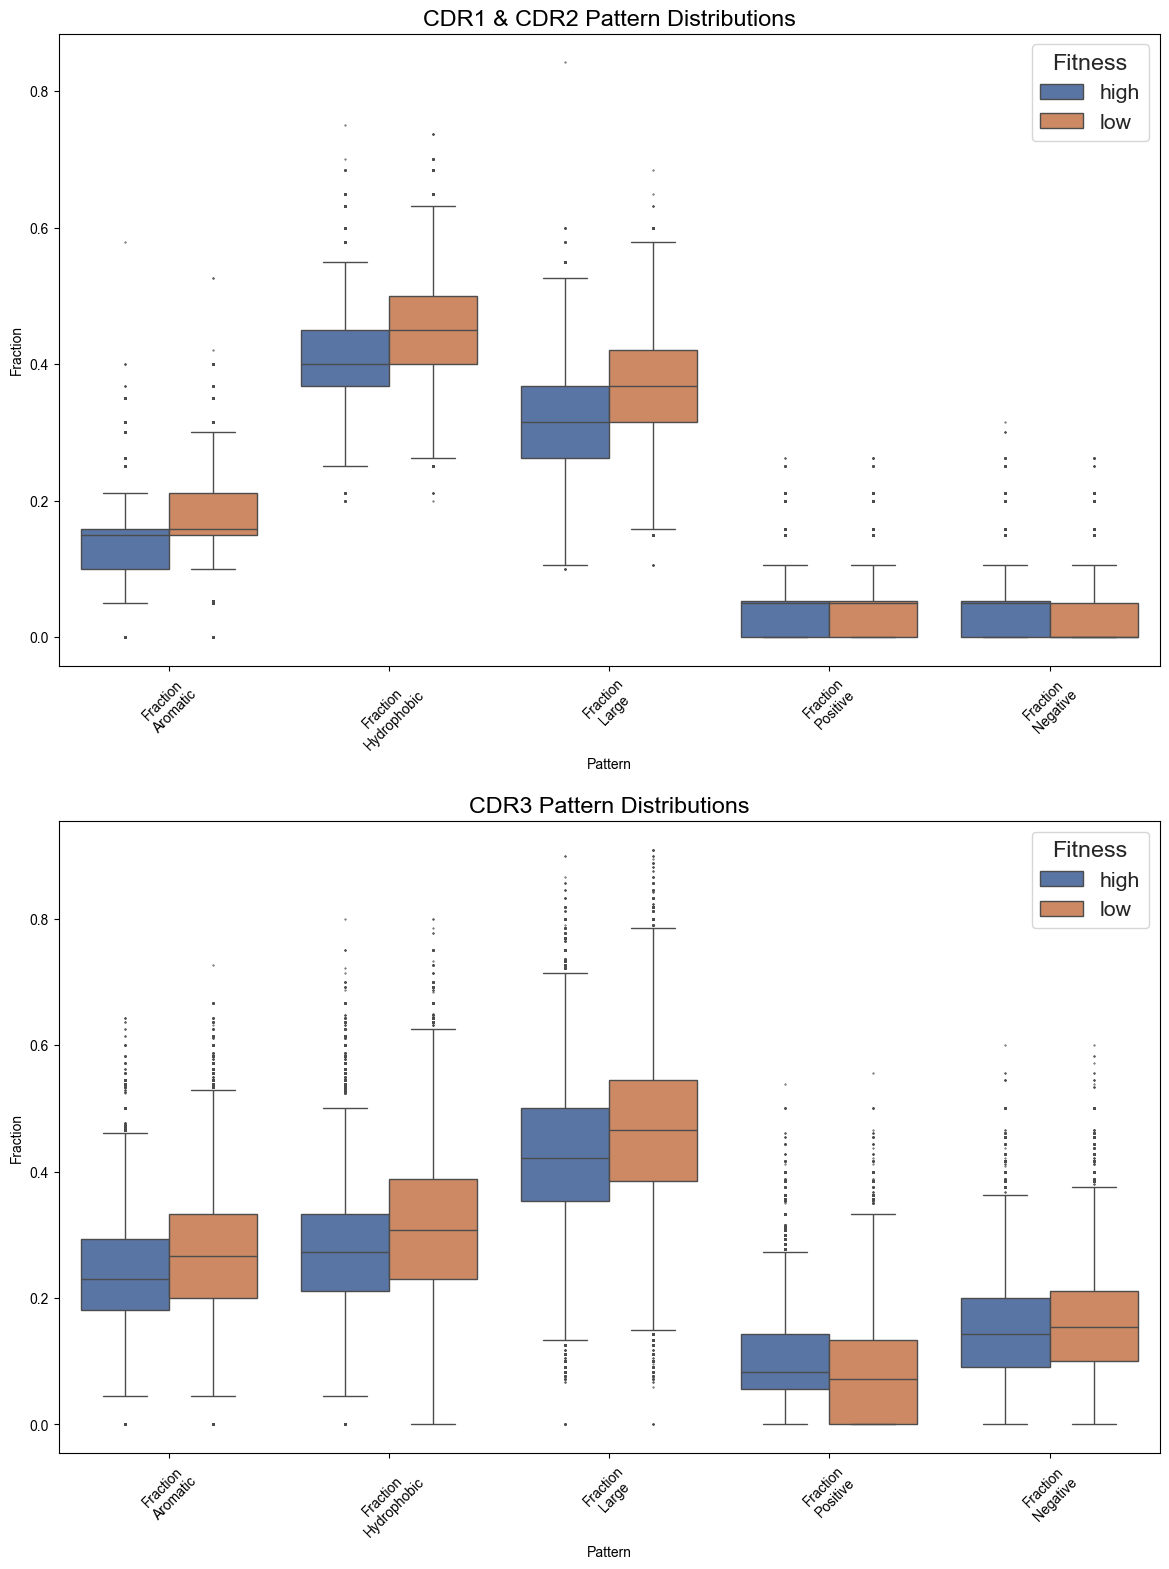

In [9]:
fig = plot_distributions(df_12_results, df_3_results, fliersize=0.5)

#save file 
fig.savefig(current_dir / 'figure_3_outputs' / 'cdr_pattern_distributions.pdf')

## Compare Models to Experimental Data

In [21]:
from nabstab.datasets.classifier_dataset import pad_internal, pad_cdr2
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score, roc_curve

In [17]:
synthetic_df = pd.read_csv(data_dir / 'experimental_data'/ 'designed_sequence.csv')
synthetic_df = synthetic_df.dropna()

synthetic_df['cdr2_padded'] = synthetic_df.CDR2.apply(pad_cdr2)
synthetic_df['cdr3_padded'] = synthetic_df.CDR3.apply(lambda x: pad_internal(x, 28))
synthetic_df['padded_sequence'] = synthetic_df.CDR1 + synthetic_df.cdr2_padded + synthetic_df.cdr3_padded

print(f"Before filtering, there are {len(synthetic_df)} records")

#filter using our criteria
synthetic_df = synthetic_df[(synthetic_df.CDR1.str.len() == 7) & (synthetic_df.CDR2.str.len().between(12,13, inclusive='both')) & (synthetic_df.CDR3.str.len() < 28)]
print(f"After filtering, there are {len(synthetic_df)} records")

Before filtering, there are 187 records
After filtering, there are 178 records


In [18]:
numseqs = torch.vstack([torch.tensor([AA2INDEX[aa] for aa in seq], dtype = torch.long) for seq in synthetic_df.padded_sequence.values])

In [20]:
batch_size = 128
lrpreds = []
cnnpreds = []
for i in range(0, numseqs.shape[0], batch_size):
    batch = numseqs[i:i+batch_size].to(device)
    with torch.no_grad():
        cnnpreds.append(cnnmodel.predict(batch, return_logits=True))
        lrpreds.append(lrmodel.predict(batch, return_logits=True))
cnn_all_preds = np.vstack(cnnpreds)
lr_all_preds = np.vstack(lrpreds)

synthetic_df['CNN'] = cnn_all_preds
synthetic_df['LR'] = lr_all_preds

In [24]:
synthetic_df_exp = pd.read_csv(data_dir / 'experimental_data'/ 'OmniLib_Design_Predictions_experimental.csv')
synthetic_df_exp = synthetic_df_exp.dropna()

synthetic_df_exp['fitness_label_binary'] = (synthetic_df_exp['experimental finess score'] > 0.5).astype(int)
#get the roc_auc
roc_auc_lr = roc_auc_score(synthetic_df_exp.fitness_label_binary, synthetic_df_exp['LR_Predictor'])
roc_auc_cnn = roc_auc_score(synthetic_df_exp.fitness_label_binary, synthetic_df_exp['CNN_Predictor'])

#get the curves to plot
fpr_lr, tpr_lr, _ = roc_curve(synthetic_df_exp.fitness_label_binary, synthetic_df_exp['LR_Predictor'])
fpr_cnn, tpr_cnn, _ = roc_curve(synthetic_df_exp.fitness_label_binary, synthetic_df_exp['CNN_Predictor'])

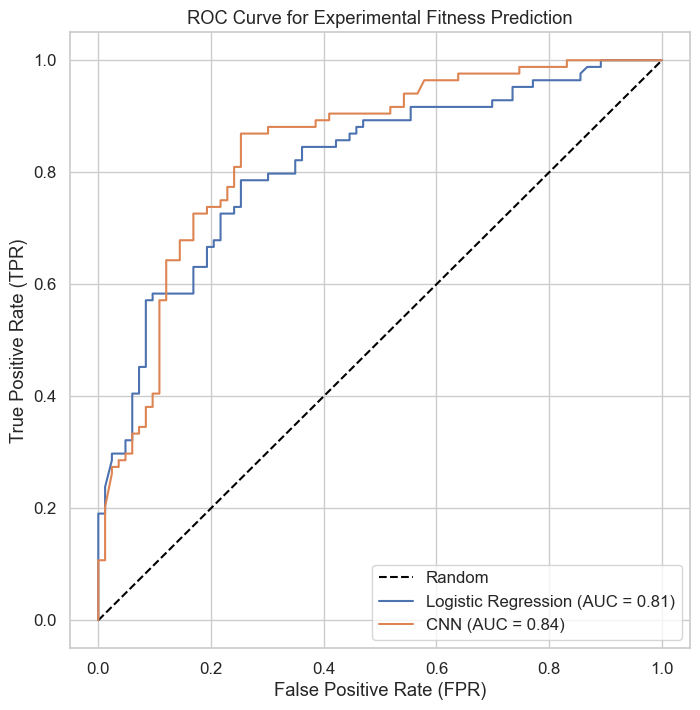

In [26]:
fig, axs = plt.subplots(figsize=(8,8))

sns.set_theme(style='whitegrid', font_scale=1.1)

axs.plot([0, 1], [0, 1],color='black', linestyle='--', label='Random')
axs.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
axs.plot(fpr_cnn, tpr_cnn, label=f'CNN (AUC = {roc_auc_cnn:.2f})')

axs.set_xlabel('False Positive Rate (FPR)')
axs.set_ylabel('True Positive Rate (TPR)')

axs.legend()

axs.set_title('ROC Curve for Experimental Fitness Prediction')

fig.savefig(current_dir / 'figure_3_outputs' / 'experimental_vs_predicted_binary_roc.pdf')